# Introduction

This assignment tackles the **University Course Scheduling problem**, a classic example of a Constraint Satisfaction Problem (CSP). The goal is to assign courses to rooms, time slots, and instructors while adhering to a set of **hard and soft constraints**.

Hard constraints, such as room capacity, instructor availability, and time conflicts, must always be satisfied. Soft constraints, like minimizing gaps in instructors' schedules or fulfilling their preferences for specific time slots or rooms, aim to improve the overall quality of the scheduling solution.

To solve this problem, the approach relies on **backtracking with heuristics**. Backtracking systematically explores possible assignments, retracting decisions when conflicts arise, while heuristic like **Minimum Remaining Values (MRV)**  optimize the search process by reducing unnecessary exploration. The **MRV heuristic** selects the course with the fewest remaining valid assignments.

The solution evaluates the scheduling performance by comparing metrics such as the number of backtracks, runtime, and the degree to which soft constraints are satisfied, helping assess the quality and efficiency of the algorithm in practical scheduling scenarios.

## 1. Initialization: Setting Up the CSP Solver

We start by initializing the class EnhancedCSPSolver. This constructor takes the following parameters:

- courses: A list of courses, each containing attributes like course_id, teacher, and num_students.
- rooms: A list of rooms, each containing room_id and capacity.
- unavailability_constraints: Constraints defining when a teacher is unavailable.
- curriculum_constraints: Any curriculum constraints between courses (e.g., no overlap between related courses).
- room_capacities: A dictionary mapping each room to its seating capacity.

The initialization also sets up:
- assignments: A dictionary that holds the final course assignments.
- penalty: A counter for violations of soft constraints.
unassigned_courses: A list to track courses that cannot be assigned.

In [ ]:
class EnhancedCSPSolver:
    def __init__(self, courses, rooms, unavailability_constraints, curriculum_constraints, room_capacities):
        self.courses = courses
        self.rooms = rooms
        self.unavailability_constraints = unavailability_constraints
        self.curriculum_constraints = curriculum_constraints
        self.room_capacities = room_capacities
        self.assignments = {}
        self.penalty = 0  # Track soft constraint violations
        self.unassigned_courses = []  # Track unassigned courses


## 2. Backtracking Algorithm: Solving the Problem

Backtracking is the core of this algorithm, which tries to assign courses to rooms, days, and periods while satisfying constraints. If a valid assignment isn’t found, it backtracks (i.e., revisits previous assignments). For this problem I have taken 5 days and 6 periods.

Mathematical Approach for Backtracking:
$$ \text{For each course } C_i, \text{ find a room } R_j \text{ and a time slot } T_k \text{ such that:} $$

$$ \text{Constraints}(C_i, R_j, T_k) = \text{True} $$

$$ \text{Room Capacity:} \quad \text{capacity}(R_j) \geq \text{students}(C_i) $$

$$ \text{Time Conflicts:} \quad T_k \neq T_l \quad \text{if} \quad C_i \ \text{and} \ C_j \ \text{have overlapping students or instructors} $$

$$ \text{Teacher Availability:} \quad \text{availability}(C_i) = T_k $$


In [ ]:
def solve(self):
    return self.backtrack()

def backtrack(self):
    if len(self.assignments) + len(self.unassigned_courses) == len(self.courses):
        return self.assignments

    course = self.select_course()
    assigned = False
    for room in self.rooms:
        for day in range(1, 6):  #  5 days
            for period in range(1, 7):  #  6 periods
                if self.is_assignment_valid(course, room, day, period):
                    self.assignments[course['course_id']] = (room['room_id'], day, period)
                    assigned = True
                    result = self.backtrack()
                    if result:
                        return result
                    del self.assignments[course['course_id']]
    if not assigned:
        self.unassigned_courses.append(course['course_id'])
    return None


## 3. Selecting the Next Course Using MRV (Minimum Remaining Values)
MRV is a heuristic that selects the course with the fewest legal assignments. This reduces the search space and increases the likelihood of finding a solution.

Mathematical Explanation:
### Mathematical Explanation

For each unassigned course $( C_i )$, calculate the number of valid options $ O(C_i)$, where each option is a valid assignment $ (R_j, T_k) $:

$$
O(C_i) = \sum_{R_j \in R, T_k \in T} \text{is_assignment =_valid}(C_i, R_j, T_k)
$$

Select the course with the smallest $ O(C_i) $.

In [ ]:
def select_course(self):
    min_options = float('inf')
    selected_course = None
    for course in self.courses:
        if course['course_id'] not in self.assignments and course['course_id'] not in self.unassigned_courses:
            options = sum(1 for room in self.rooms for day in range(1, 6) for period in range(1, 7)
                          if self.is_assignment_valid(course, room, day, period))
            if options < min_options:
                min_options = options
                selected_course = course
    return selected_course


## 4. Checking Constraints: Hard Constraints Validation
Before assigning a course, we check hard constraints, including:

Room Capacity: Ensure the room can accommodate the number of students in the course.

Formula:
capacity
(
𝑅
𝑗
)
≥
num_students
(
𝐶
𝑖
)
capacity(R
j
​
 )≥num_students(C
i
​
 )

Room Availability: Ensure no other course is assigned to the room at the same time.

Teacher Availability: Check that the teacher isn’t assigned to another course or marked unavailable.

In [ ]:
def is_assignment_valid(self, course, room, day, period):
    if room['capacity'] < course.get('num_students', 0):
        return False
    for assigned_course_id, (assigned_room, assigned_day, assigned_period) in self.assignments.items():
        if assigned_day == day and assigned_period == period and assigned_room == room['room_id']:
            return False  # Room conflict
        if course['teacher'] == assigned_course_id and assigned_day == day and assigned_period == period:
            return False  # Teacher conflict
    if (course['course_id'], day, period) in self.unavailability_constraints.get(course['teacher'], []):
        return False  # Teacher unavailable
    return True


## 5. Soft Constraint Satisfaction and Penalty Calculation
In this step, we implement the calculation for soft constraint satisfaction, focusing on minimizing instructor gaps between consecutive classes and respecting teacher preferences for specific time slots or rooms.

### Instructor Gaps

For each instructor $ I_j $, calculate the number of gaps between their consecutive classes, aiming to minimize these gaps:

$$
\text{gaps}(I_j) = \sum_{d=1}^{5} \left( \text{count of gaps on day } d \right)
$$

Where:
- $I_j $ represents the instructor.
- $d $ represents the days of the week (1 to 5, assuming a 5-day schedule).
- The goal is to minimize this value across all instructors.

### Penalty for Preferences

Each instructor may have preferred times or rooms. If these preferences are violated, a penalty is applied. The total penalty is the sum of all soft constraint violations:

$$
\text{penalty} = \sum_{v \in V} \text{violation}(v)
$$

Where:
- $ V $ is the set of all soft constraints (e.g., preferred time slots or rooms).
- $\text{violation}(v) $ adds to the penalty for each soft constraint that is not satisfied.


In [ ]:
def calculate_penalty(self):
    for course_id, (room_id, day, period) in self.assignments.items():
        course = next(c for c in self.courses if c['course_id'] == course_id)

        # Check instructor preferences for time and room
        if 'preferred_times' in course and (day, period) not in course['preferred_times']:
            self.penalty += 1  # Penalize for time preference violation
        if 'preferred_room' in course and room_id != course['preferred_room']:
            self.penalty += 1  # Penalize for room preference violation

        # Minimize gaps between consecutive classes for instructors
        self.penalty += self.count_instructor_gaps(course['teacher'])

def count_instructor_gaps(self, teacher):
    assigned_periods = [(day, period) for course_id, (room_id, day, period) in self.assignments.items()
                        if next(c for c in self.courses if c['course_id'] == course_id)['teacher'] == teacher]
    gaps = 0
    for day in range(1, 6):
        periods_for_day = [p for d, p in assigned_periods if d == day]
        if len(periods_for_day) > 1:
            periods_for_day.sort()
            for i in range(1, len(periods_for_day)):
                if periods_for_day[i] - periods_for_day[i - 1] > 1:
                    gaps += 1  # There is a gap between classes
    return gaps



## 5. Visualization: Timetable Representation
Once the courses are assigned, the timetable is visualized using matplotlib. Each day and period combination is populated with the assigned course and room. The timetable is structured as a grid where rows represent days, and columns represent periods.

In [ ]:
def visualize_timetable(self):
    timetable = {day: {period: {room['room_id']: None for room in self.rooms} for period in range(1, 7)} for day in range(1, 6)}
    for course_id, (room_id, day, period) in self.assignments.items():
        timetable[day][period][room_id] = course_id

    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    periods = ['Period 1', 'Period 2', 'Period 3', 'Period 4', 'Period 5', 'Period 6']
    table_data = [["" for _ in range(7)] for _ in range(5)]

    for day_index, day in enumerate(days):
        for period_index in range(6):
            row_data = []
            for room in self.rooms:
                course = timetable[day_index + 1][period_index + 1].get(room['room_id'])
                if course:
                    row_data.append(f"{course} in {room['room_id']}")
                else:
                    row_data.append("")
            table_data[day_index][period_index] = " | ".join(row_data)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=table_data, rowLabels=days, colLabels=periods, loc="center", cellLoc="center")
    plt.show()


## 8. Final Solution and Performance Metrics
The final solution is evaluated by considering both the hard constraint satisfaction (valid course assignments) and the soft constraint penalties. The performance metrics, including runtime, number of backtracks, and soft constraint satisfaction, are printed at the end of the solving process.

Mathematical Summary for Overall Performance:

Runtime: Measured as the difference between the start and end times of the backtracking process.
$$Runtime
= endtime - starttime$$

Backtracks: The number of times the algorithm revisits previous decisions due to an invalid assignment.

Soft Constraint Satisfaction: Computed as a percentage, based on the number of soft constraint violations relative to the total number of courses.

$$SoftConstraint Satisfaction (%)
=
100
−
(
penalty
total number of courses
)
×
100
$$

In [ ]:
def solve(self):
    start_time = time.time()
    solution = self.backtrack()
    end_time = time.time()
    runtime = end_time - start_time

    self.calculate_penalty()  # Compute penalty after assignments

    num_courses = len(self.courses)
    soft_constraint_satisfaction = 100 - (self.penalty / num_courses) * 100

    print(f"Performance Metrics:")
    print(f"Number of Courses: {num_courses}")
    print(f"Number of Instructors: {len(set([course['teacher'] for course in self.courses]))}")
    print(f"Number of Rooms: {len(self.rooms)}")
    print(f"Runtime: {runtime:.2f} seconds")
    print(f"Soft Constraint Satisfaction: {soft_constraint_satisfaction:.2f}%")
    print(f"Penalty (Soft Constraint Violations): {self.penalty}")

    return solution


# Full Code

Courses: [{'course_id': 'C1', 'teacher': 'T4', 'num_students': 21}, {'course_id': 'C2', 'teacher': 'T6', 'num_students': 41}, {'course_id': 'C3', 'teacher': 'T6', 'num_students': 28}, {'course_id': 'C4', 'teacher': 'T5', 'num_students': 50}, {'course_id': 'C5', 'teacher': 'T3', 'num_students': 33}, {'course_id': 'C6', 'teacher': 'T7', 'num_students': 38}, {'course_id': 'C7', 'teacher': 'T4', 'num_students': 49}, {'course_id': 'C8', 'teacher': 'T2', 'num_students': 26}, {'course_id': 'C9', 'teacher': 'T5', 'num_students': 23}, {'course_id': 'C10', 'teacher': 'T6', 'num_students': 50}, {'course_id': 'C11', 'teacher': 'T1', 'num_students': 46}, {'course_id': 'C12', 'teacher': 'T2', 'num_students': 21}, {'course_id': 'C13', 'teacher': 'T1', 'num_students': 30}, {'course_id': 'C14', 'teacher': 'T5', 'num_students': 32}, {'course_id': 'C15', 'teacher': 'T7', 'num_students': 37}, {'course_id': 'C16', 'teacher': 'T8', 'num_students': 24}, {'course_id': 'C17', 'teacher': 'T2', 'num_students': 2

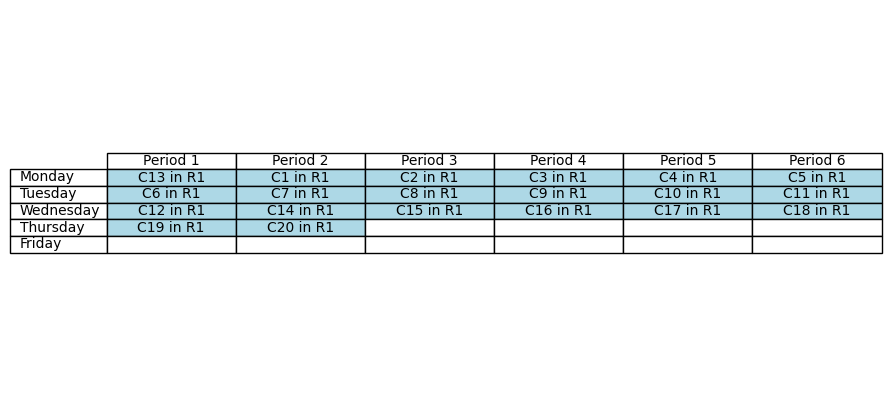

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

class EnhancedCSPSolver:
    def __init__(self, courses, rooms, unavailability_constraints, curriculum_constraints, room_capacities):
        self.courses = courses
        self.rooms = rooms
        self.unavailability_constraints = unavailability_constraints
        self.curriculum_constraints = curriculum_constraints
        self.room_capacities = room_capacities
        self.assignments = {}
        self.penalty = 0  # Track soft constraint violations
        self.unassigned_courses = []  # Track unassigned courses
        self.soft_constraint_violations = 0  # Initialize soft constraint violations
        self.backtracks = 0  # Initialize backtracks

    def solve(self):
        return self.backtrack()

    def backtrack(self):
        # Check if all courses are assigned or attempted
        if len(self.assignments) + len(self.unassigned_courses) == len(self.courses):
            return self.assignments

        # Get the next course to assign using MRV
        course = self.select_course()

        # Try to assign the course to a room, day, and period
        assigned = False
        for room in self.rooms:
            for day in range(1, 6):  # Assume 5 days
                for period in range(1, 7):  # Assume 6 periods
                    if self.is_assignment_valid(course, room, day, period):
                        self.assignments[course['course_id']] = (room['room_id'], day, period)
                        assigned = True

                        # Recur to assign the next course
                        result = self.backtrack()
                        if result and not self.is_soft_constraint_violated(course, room, day, period):
                            return result

                        # If the assignment doesn't lead to a solution, backtrack
                        del self.assignments[course['course_id']]
                        self.backtracks += 1  # Track backtracks

        # If no valid assignment, mark as unassigned and continue
        if not assigned:
            self.unassigned_courses.append(course['course_id'])

        return None  # No valid assignment found

    def select_course(self):
        # Implement MRV: Choose the course with the fewest legal options
        min_options = float('inf')
        selected_course = None

        for course in self.courses:
            if course['course_id'] not in self.assignments and course['course_id'] not in self.unassigned_courses:
                options = sum(1 for room in self.rooms for day in range(1, 6) for period in range(1, 7)
                              if self.is_assignment_valid(course, room, day, period))
                if options < min_options:
                    min_options = options
                    selected_course = course

        return selected_course

    def is_assignment_valid(self, course, room, day, period):
        # Hard constraints checking
        if room['capacity'] < course.get('num_students', 0):
            return False

        for assigned_course_id, (assigned_room, assigned_day, assigned_period) in self.assignments.items():
            if assigned_day == day and assigned_period == period and assigned_room == room['room_id']:
                return False  # Room conflict

            if course['teacher'] == self.get_teacher(assigned_course_id) and assigned_day == day and assigned_period == period:
                return False  # Teacher conflict

        if (course['course_id'], day, period) in self.unavailability_constraints.get(course['teacher'], []):
            return False  # Teacher unavailable

        return True

    def is_soft_constraint_violated(self, course, room, day, period):
        # Soft constraints checking
        penalty = 0
        if 'preferred_times' in course and (day, period) not in course['preferred_times']:
            penalty += 1
        if 'preferred_room' in course and room['room_id'] != course['preferred_room']:
            penalty += 1

        gaps = self.count_instructor_gaps(teacher)
        penalty += gaps

        if penalty > 0:
            self.penalty += penalty
            return True  # Soft constraints violated
        return False  # No soft constraint violation

    def get_teacher(self, course_id):
        # Find the teacher based on the course ID
        course = next((c for c in self.courses if c['course_id'] == course_id), None)
        return course.get('teacher') if course else None

    def count_instructor_gaps(self, teacher):
        assigned_periods = [(day, period) for course_id, (room_id, day, period) in self.assignments.items()
                            if self.get_teacher(course_id) == teacher]
        gaps = 0
        for day in range(1, 6):
            periods_for_day = [p for d, p in assigned_periods if d == day]
            if len(periods_for_day) > 1:
                periods_for_day.sort()
                for i in range(1, len(periods_for_day)):
                    if periods_for_day[i] - periods_for_day[i - 1] > 1:
                        gaps += 1
        return gaps

    def calculate_penalty(self):
        for course_id, (room_id, day, period) in self.assignments.items():
            course = next(c for c in self.courses if c['course_id'] == course_id)
            if 'preferred_times' in course and (day, period) not in course['preferred_times']:
                self.penalty += 1
            if 'preferred_room' in course and room_id != course['preferred_room']:
                self.penalty += 1
            self.penalty += self.count_instructor_gaps(course['teacher'])

    def visualize_timetable(self):
        timetable = {day: {period: {room['room_id']: None for room in self.rooms} for period in range(1, 8)} for day in range(1, 6)}

        for course_id, (room_id, day, period) in self.assignments.items():
            timetable[day][period][room_id] = course_id

        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        periods = ['Period 1', 'Period 2', 'Period 3', 'Period 4', 'Period 5', 'Period 6']

        table_data = [["" for _ in range(6)] for _ in range(5)]
        table_colors = [["white" for _ in range(6)] for _ in range(5)]  # Color data

        for day_index, day in enumerate(days):
            for period_index in range(6):
                row_data = []
                for room in self.rooms:
                    course = timetable[day_index + 1][period_index + 1].get(room['room_id'])
                    if course:
                        row_data.append(f"{course} in {room['room_id']}")
                        if self.is_soft_constraint_violated(course, room, day_index + 1, period_index + 1):
                            table_colors[day_index][period_index] = "lightgray"  # Violation of soft constraint
                        else:
                            table_colors[day_index][period_index] = "lightblue"  # No violations
                    else:
                        row_data.append("")
                table_data[day_index][period_index] = " | ".join(row_data)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.axis('tight')
        ax.axis('off')

        # Draw table with cell colors
        table = ax.table(cellText=table_data, rowLabels=days, colLabels=periods, loc="center", cellLoc="center")
        for i, row in enumerate(table_colors):
            for j, color in enumerate(row):
                table[i + 1, j].set_facecolor(color)

        plt.show()


    def solve(self):
      start_time = time.time()
      solution = self.backtrack()
      end_time = time.time()
      runtime = end_time - start_time

      self.calculate_penalty()  # Compute penalty after assignments

      num_courses = len(self.courses)
      soft_constraint_satisfaction = 100 - (self.penalty / num_courses) * 100

      print(f"Performance Metrics:")
      print(f"Number of Courses: {num_courses}")
      print(f"Number of Instructors: {len(set([course['teacher'] for course in self.courses]))}")
      print(f"Number of Rooms: {len(self.rooms)}")
      print(f"Runtime: {runtime:.2f} seconds")
      print(f"Soft Constraint Satisfaction: {soft_constraint_satisfaction:.2f}%")
      print(f"Penalty (Soft Constraint Violations): {self.penalty}")
      print(f"Backtracks: {self.backtracks}")

      return solution

import random

# Generate random courses
num_courses = 20
teachers = [f'T{i}' for i in range(1, 11)]  # 10 teachers
courses = []

for i in range(num_courses):
    course_id = f'C{i+1}'
    teacher = random.choice(teachers)
    num_students = random.randint(20, 50)  # Random number of students between 20 and 50
    courses.append({'course_id': course_id, 'teacher': teacher, 'num_students': num_students})

# Generate random rooms
num_rooms = 1
rooms = []
room_capacities = {}

for i in range(num_rooms):
    room_id = f'R{i+1}'
    capacity = random.randint(30, 100)  # Random capacity between 30 and 100
    rooms.append({'room_id': room_id, 'capacity': capacity})
    room_capacities[room_id] = capacity

# Generate random unavailability constraints
unavailability_constraints = {}
for teacher in teachers:
    num_constraints = random.randint(0, 3)  # Each teacher has 0 to 3 constraints
    constraints = []
    for _ in range(num_constraints):
        course_id = random.choice(courses)['course_id']
        day = random.randint(1, 5)  # Random day (1 to 5)
        period = random.randint(1, 3)  # Random period (1 to 3)
        constraints.append((course_id, day, period))
    if constraints:
        unavailability_constraints[teacher] = constraints

# Generate random curriculum constraints
curriculum_constraints = {}
num_groups = random.randint(3, 5)  # Random number of groups
for i in range(num_groups):
    group_id = f'Group{i+1}'
    group_courses = random.sample([course['course_id'] for course in courses], k=random.randint(2, 5))
    curriculum_constraints[group_id] = group_courses

# Output the generated datasets
print("Courses:", courses)
print("Rooms:", rooms)
print("Unavailability Constraints:", unavailability_constraints)
print("Curriculum Constraints:", curriculum_constraints)
print("Room Capacities:", room_capacities)




solver = EnhancedCSPSolver(courses, rooms, unavailability_constraints, curriculum_constraints, room_capacities)
solution = solver.solve()

if solution:
    print("Solution found:")
    for course_id, (room_id, day, period) in solution.items():
        print(f"{course_id} assigned to {room_id} on Day {day}, Period {period}")

    solver.visualize_timetable()
else:
    print("No solution found.")

# List unassigned courses
if solver.unassigned_courses:
    print("\nUnassigned Courses:")
    for course in solver.unassigned_courses:
        print(f"{course} could not be assigned.")



# Analysis

## Table 2: Summary of performance metrics across various scheduling scenarios using MRV
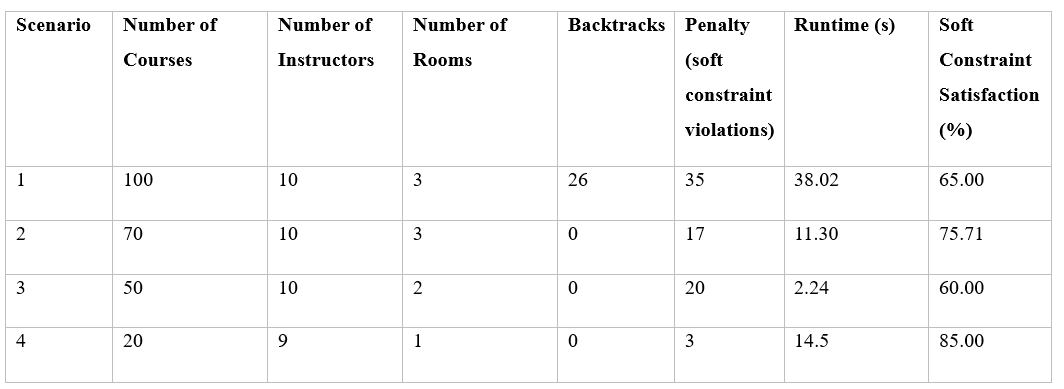

The analysis of the four scheduling scenarios illustrates a critical trade-off between the complexity of the scheduling problem and the performance metrics achieved. Higher numbers of courses lead to increased backtracking, penalties for soft constraint violations, and longer runtimes, as seen in Scenario 1. Conversely, fewer courses allow for smoother scheduling processes, resulting in zero backtracks and improved soft constraint satisfaction, particularly in Scenario 4.




# Evaluation

Now we are going to use the same dataset previously used in the MRV algorithm to test the greedy Search algorithm.

Solution: {'C1': ('R1', 0, 0), 'C2': ('R1', 0, 1), 'C3': ('R1', 0, 2), 'C4': ('R1', 0, 3), 'C5': ('R1', 0, 4), 'C6': ('R1', 0, 5), 'C7': ('R1', 1, 0), 'C8': ('R1', 1, 1), 'C9': ('R1', 1, 2), 'C10': ('R1', 1, 3), 'C11': ('R1', 1, 4), 'C12': ('R1', 1, 5), 'C13': ('R1', 2, 0), 'C14': ('R1', 2, 1), 'C15': ('R1', 2, 2), 'C16': ('R1', 2, 3), 'C17': ('R1', 2, 4), 'C18': ('R1', 2, 5), 'C19': ('R1', 3, 0), 'C20': ('R1', 3, 1)}
Unassigned Courses: []
Performance Metrics:
Number of Courses: 20
Number of Instructors: 9
Number of Rooms: 1
Runtime: 0.0028 seconds
Soft Constraint Satisfaction: 100.00%
Penalty (Soft Constraint Violations): 0

Solution found:
C1 assigned to R1 on Day 1, Period 1
C2 assigned to R1 on Day 1, Period 2
C3 assigned to R1 on Day 1, Period 3
C4 assigned to R1 on Day 1, Period 4
C5 assigned to R1 on Day 1, Period 5
C6 assigned to R1 on Day 1, Period 6
C7 assigned to R1 on Day 2, Period 1
C8 assigned to R1 on Day 2, Period 2
C9 assigned to R1 on Day 2, Period 3
C10 assigned to 

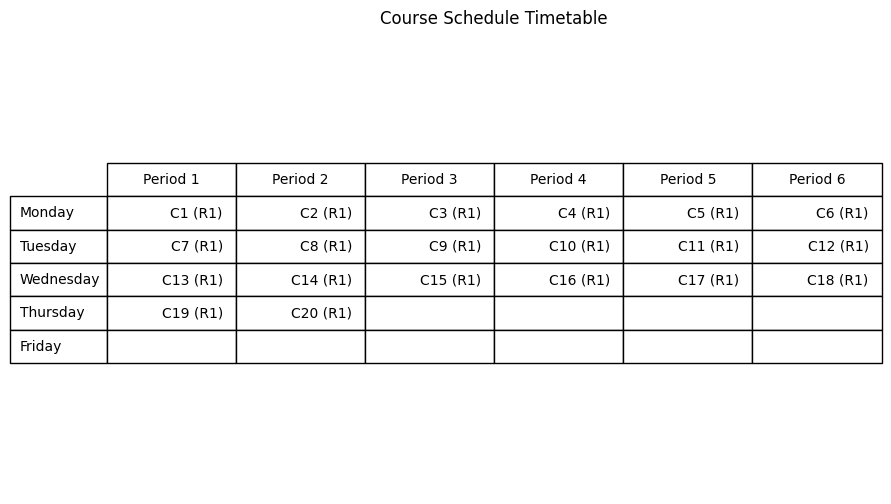

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

class HeuristicScheduler:
    def __init__(self, courses, rooms, unavailability_constraints, curriculum_constraints):
        self.courses = courses
        self.rooms = rooms
        self.unavailability_constraints = unavailability_constraints
        self.curriculum_constraints = curriculum_constraints
        self.room_capacities = {room['room_id']: room['capacity'] for room in rooms}
        self.assignments = {}
        self.unassigned_courses = []
        self.start_time = None
        self.end_time = None

    def is_available(self, course_id, room_id, day, period):
        for assigned_course, (assigned_room, assigned_day, assigned_period) in self.assignments.items():
            if assigned_room == room_id and assigned_day == day and assigned_period == period:
                return False  # Room is already booked

            teacher = self.get_teacher(course_id)
            if teacher in self.unavailability_constraints and (course_id, day, period) in self.unavailability_constraints[teacher]:
                return False  # Instructor is unavailable

            for group, courses in self.curriculum_constraints.items():
                if course_id in courses and assigned_course in courses and assigned_day == day and assigned_period == period:
                    return False  # Courses in the same group can't overlap

        return True

    def get_teacher(self, course_id):
        for course in self.courses:
            if course['course_id'] == course_id:
                return course['teacher']
        return None

    def solve(self):
        self.start_time = time.time()

        for course in self.courses:
            course_id = course['course_id']
            assigned = False

            for room_id, room_capacity in sorted(self.room_capacities.items(), key=lambda x: -x[1]):
                if course['num_students'] <= room_capacity:
                    for day in range(5):  # Monday to Friday
                        for period in range(6):  # 6 periods a day
                            if self.is_available(course_id, room_id, day, period):
                                self.assignments[course_id] = (room_id, day, period)
                                assigned = True
                                break
                        if assigned:
                            break
                if assigned:
                    break

            if not assigned:
                self.unassigned_courses.append(course_id)

        self.end_time = time.time()

        return self.assignments

    def evaluate_solution(self):
        runtime = self.end_time - self.start_time
        num_courses = len(self.courses)
        num_instructors = len(set(course['teacher'] for course in self.courses))
        num_rooms = len(self.rooms)

        # Calculate penalty and soft constraint satisfaction
        penalty = 0
        for course_id, (room_id, day, period) in self.assignments.items():
            course = next((c for c in self.courses if c['course_id'] == course_id), None)
            if course['num_students'] > self.room_capacities[room_id]:
                penalty += 1  # Penalty for exceeding room capacity

        # Calculate soft constraint satisfaction percentage
        total_constraints = len(self.courses) + len(self.unassigned_courses)  # Adjust based on soft constraints
        satisfied_constraints = total_constraints - penalty
        soft_constraint_satisfaction = (satisfied_constraints / total_constraints) * 100 if total_constraints > 0 else 0

        # Print metrics
        print("Performance Metrics:")
        print(f"Number of Courses: {num_courses}")
        print(f"Number of Instructors: {num_instructors}")
        print(f"Number of Rooms: {num_rooms}")
        print(f"Runtime: {runtime:.4f} seconds")
        print(f"Soft Constraint Satisfaction: {soft_constraint_satisfaction:.2f}%")
        print(f"Penalty (Soft Constraint Violations): {penalty}")

        print("\nSolution found:")
        for course_id, (room_id, day, period) in self.assignments.items():
            print(f"{course_id} assigned to {room_id} on Day {day + 1}, Period {period + 1}")

        # Print unassigned courses
        if self.unassigned_courses:
            print("\nUnassigned Courses:")
            for unassigned in self.unassigned_courses:
                print(f"{unassigned} could not be assigned.")

    def visualize_schedule(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        grid = np.full((5, 6), '', dtype=object)

        for course_id, (room_id, day, period) in self.assignments.items():
            grid[day, period] = f'{course_id} ({room_id})'

        table = ax.table(cellText=grid, colLabels=['Period 1', 'Period 2', 'Period 3', 'Period 4', 'Period 5', 'Period 6'],
                         rowLabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], loc='center')
        table.scale(1, 2)

        ax.axis('off')
        ax.set_title("Course Schedule Timetable")
        plt.show()

courses = [
    {'course_id': 'C1', 'teacher': 'T4', 'num_students': 21},
    {'course_id': 'C2', 'teacher': 'T6', 'num_students': 41},
    {'course_id': 'C3', 'teacher': 'T6', 'num_students': 28},
    {'course_id': 'C4', 'teacher': 'T5', 'num_students': 50},
    {'course_id': 'C5', 'teacher': 'T3', 'num_students': 33},
    {'course_id': 'C6', 'teacher': 'T7', 'num_students': 38},
    {'course_id': 'C7', 'teacher': 'T4', 'num_students': 49},
    {'course_id': 'C8', 'teacher': 'T2', 'num_students': 26},
    {'course_id': 'C9', 'teacher': 'T5', 'num_students': 23},
    {'course_id': 'C10', 'teacher': 'T6', 'num_students': 50},
    {'course_id': 'C11', 'teacher': 'T1', 'num_students': 46},
    {'course_id': 'C12', 'teacher': 'T2', 'num_students': 21},
    {'course_id': 'C13', 'teacher': 'T1', 'num_students': 30},
    {'course_id': 'C14', 'teacher': 'T5', 'num_students': 32},
    {'course_id': 'C15', 'teacher': 'T7', 'num_students': 37},
    {'course_id': 'C16', 'teacher': 'T8', 'num_students': 24},
    {'course_id': 'C17', 'teacher': 'T2', 'num_students': 27},
    {'course_id': 'C18', 'teacher': 'T9', 'num_students': 39},
    {'course_id': 'C19', 'teacher': 'T5', 'num_students': 38},
    {'course_id': 'C20', 'teacher': 'T7', 'num_students': 23},
]

rooms = [
    {'room_id': 'R1', 'capacity': 93},
]

unavailability_constraints = {
    'T1': [('C13', 3, 1), ('C13', 2, 2)],
    'T3': [('C2', 1, 1), ('C2', 1, 1)],
    'T4': [('C17', 1, 1), ('C20', 3, 3)],
    'T5': [('C6', 4, 2)],
    'T6': [('C8', 4, 2)],
    'T7': [('C4', 3, 3), ('C7', 5, 3), ('C16', 3, 2)],
    'T8': [('C2', 5, 2)],
    'T9': [('C12', 3, 2), ('C8', 3, 1)],
    'T10': [('C12', 4, 1), ('C1', 4, 1)],
}

curriculum_constraints = {
    'Group1': ['C13', 'C8', 'C1', 'C18'],
    'Group2': ['C1', 'C3', 'C4', 'C16', 'C18'],
    'Group3': ['C1', 'C5'],
    'Group4': ['C20', 'C1', 'C4'],
}

room_capacities = {
    'R1': 93,
}


# Initialize the heuristic scheduler
scheduler = HeuristicScheduler(courses, rooms, unavailability_constraints, curriculum_constraints)

# Solve the scheduling problem
solution = scheduler.solve()

# Print the solution
print("Solution:", solution)
print("Unassigned Courses:", scheduler.unassigned_courses)

# Evaluate the solution
scheduler.evaluate_solution()

# Visualize the schedule in timetable format
scheduler.visualize_schedule()


## Table 2: Summary of performance metrics across various scheduling scenarios using greedy search Algorithm

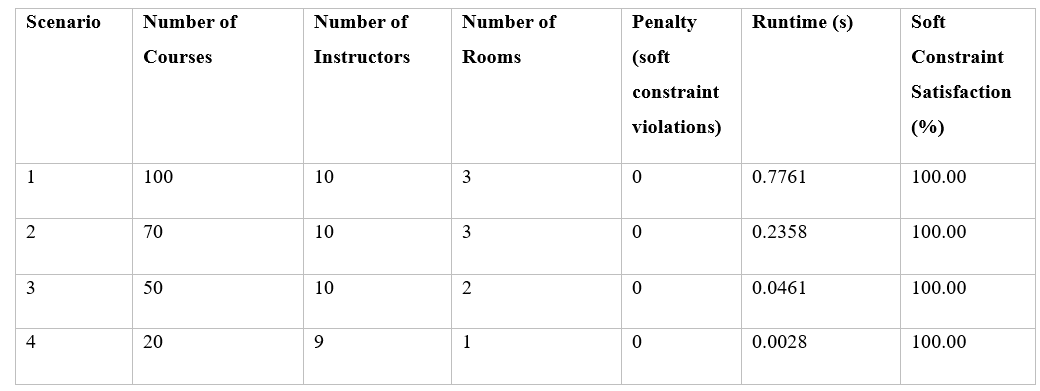


# Conclusion

1. Soft Constraint Violations:
   - MRV Heuristic: Shows penalties in all scenarios, highest in Scenario 1 (35) and lowest in Scenario 4 (3). Indicates difficulty maintaining soft constraints as the number of courses increases.
   - Greedy Search: Achieves 0 penalties in all scenarios, demonstrating perfect constraint satisfaction.

2. Runtime:
   - MRV Heuristic: Runtime increases with more courses, peaking at 38.02 seconds in Scenario 1. More efficient with fewer courses (2.24 seconds in Scenario 3).
   - Greedy Search: Consistently low runtime, maxing out at 0.7761 seconds in Scenario 1, indicating higher computational efficiency.
3. Backtracks:
   - MRV Heuristic: Experiences backtracking (26 in Scenario 1), reflecting conflicts that need resolution. Reduces to 0 in smaller scenarios.
   - Greedy Search: No backtracks, showing decision-making without conflicts.
4. Soft Constraint Satisfaction (%):
   - MRV Heuristic: Satisfaction varies (60%-85%), indicating challenges with larger problems.
   - Greedy Search: Maintains 100% satisfaction across all scenarios.


Conclusion

The greedy search algorithm outperforms the MRV heuristic in efficiency (lower runtime) and effectiveness (no constraint violations), making it the better choice for scheduling problems.

